## Проект: Обучение с учителем: качество модели

***Описание проекта***

    Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже             продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать 
    новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный 
    выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
    
    «В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только 
    на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит 
    побыть в роли стажёра в этом отделе. 
    
    Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным 
    клиентам, чтобы увеличить их покупательскую активность.

In [2]:
import numpy as np
import warnings

import shap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from phik import phik_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    RobustScaler
)
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [4]:
warnings.filterwarnings('ignore')

## Загрузка данных

In [ ]:
def read_file(try_file, except_file, sep):
    try:
        try:
            data_file = pd.read_csv(try_file, sep=sep)
        except:
            data_file = pd.read_csv(try_file)
    except:
        try:
            data_file = pd.read_csv(except_file, sep=sep)
        except:
            data_file = pd.read_csv(except_file)
    return data_file

market_file = read_file('YOUR_DATA', 'YOUR_DATA', '')
market_money = read_file('YOUR_DATA', 'YOUR_DATA', '')
market_time = read_file('YOUR_DATA', 'YOUR_DATA', '')
money = read_file('YOUR_DATA', 'YOUR_DATA', ';')

In [6]:
def df_info(df):
    print()
    return df.info()

df_info(market_file)
df_info(market_money)
df_info(market_time)
df_info(money)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса               

## Описание данных

***market_file.csv*** - таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
    
    id — номер покупателя в корпоративной базе данных.
    
    Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» 
    или «прежний уровень».
    
    Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
    
    Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. 
    Согласие на это даёт покупатель.
    
    Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на 
    покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы 
    и прочего приходилось на клиента.
    
    Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
    
    Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
    
    Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
    
    Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
    
    Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит 
    в течение последнего месяца.
    
    Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
    
    Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
    
    Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за 
    последние 3 месяца.

***market_money.csv*** - таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
    
    id — номер покупателя в корпоративной базе данных.
    
    Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
    
    Выручка — сумма выручки за период.

***market_time.csv*** - таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

    id — номер покупателя в корпоративной базе данных.
    
    Период — название периода, во время которого зафиксировано общее время.
    
    Минут — значение времени, проведённого на сайте, в минутах.

***money.csv*** - таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

    id — номер покупателя в корпоративной базе данных.
    
    Прибыль — значение прибыли.

##  Предобработка данных

In [7]:
market_file = market_file.set_index('id')

In [8]:
market_file = market_file.rename(columns={'Покупательская активность': 'Покупательская_активность',
                                          'Тип сервиса': 'Тип_сервиса',
                                          'Разрешить сообщать': 'Разрешить_сообщать'})

market_file['Тип_сервиса'] = market_file['Тип_сервиса'].replace('стандартт', 'стандарт')
market_file['Маркет_актив_6_мес'] = np.floor(market_file['Маркет_актив_6_мес']).astype(int)
display(market_file.isna().sum())

Покупательская_активность              0
Тип_сервиса                            0
Разрешить_сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

Установил столбец id как индекс, переименовал несколько столбцов и подправил сами данные, ошибки были найдены в исследовательском анализе

In [9]:
market_money = market_money.set_index('id')
market_money = market_money[market_money['Выручка'] != 106862.200000]
display(market_money.isna().sum())

Период     0
Выручка    0
dtype: int64

Установил столбец id как индекс, удалил выброс

In [10]:
market_time = market_time.set_index('id')
market_time['Период'] = market_time['Период'].replace('предыдцщий_месяц', 'предыдущий_месяц')
display(market_time.isna().sum())

Период    0
минут     0
dtype: int64

Установил столбец id как индекс, исправил ошибку в данных

In [11]:
money = money.set_index('id')
money['Прибыль'] = money['Прибыль'].str.replace(',', '.').astype(float)
display(money.isna().sum())

Прибыль    0
dtype: int64

Установил столбец id как индекс, поменял тип данных

Во всех датасетах установил общий столбец id как индекс, чтобы по нему в будущем соединить таблицы и подправил данные

## Исследовательский анализ

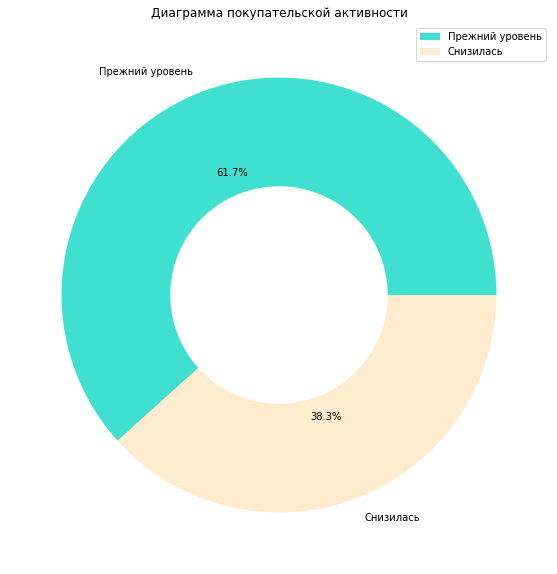

In [12]:
market_file['Покупательская_активность'].value_counts().plot(
    kind='pie',
    figsize=(10, 10),
    autopct='%1.1f%%',
    title='Диаграмма покупательской активности',
    ylabel='',
    wedgeprops={'width': 0.5},
    colors=['#40E0D0', '#FFEBCD']);

plt.legend()
plt.show()

Покупательская активность чаще остается на прежнем уровне(61.7%), чем снижается(38.3%)

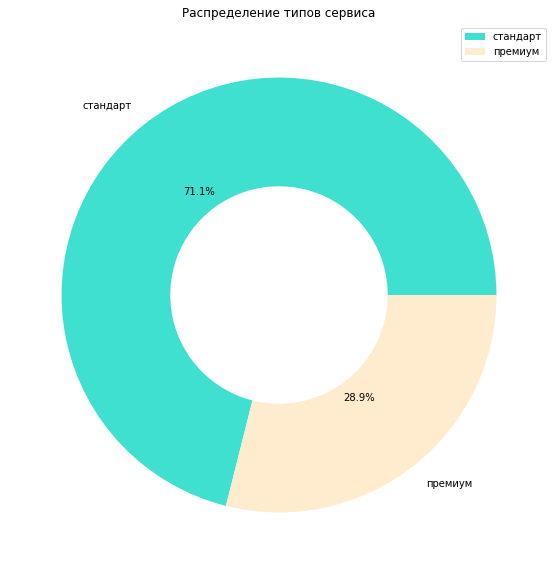

In [13]:
market_file['Тип_сервиса'].value_counts().plot(
    kind='pie',
    figsize=(10, 10),
    autopct='%1.1f%%',
    title='Распределение типов сервиса',
    ylabel='',
    wedgeprops={'width': 0.5},
    colors=['#40E0D0', '#FFEBCD']);

plt.legend()
plt.show()

В распределении типов сервиса стандартных пользователей больше чем премиум - 71.1% против 28.9% соответственно

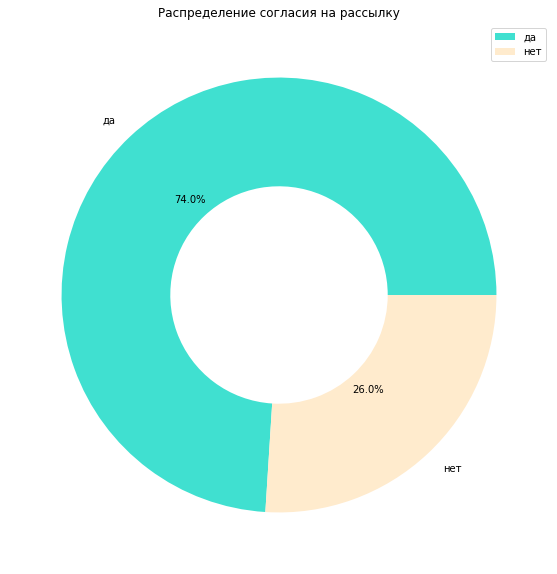

In [14]:
market_file['Разрешить_сообщать'].value_counts().plot(
    kind='pie',
    figsize=(10, 10),
    autopct='%1.1f%%',
    title='Распределение согласия на рассылку',
    ylabel='',
    wedgeprops={'width': 0.5},
    colors=['#40E0D0', '#FFEBCD']);

plt.legend()
plt.show()

Большинство людей соглашаются на рассылку от интернет-магазина, 74% - согласны, 26% - не согласны

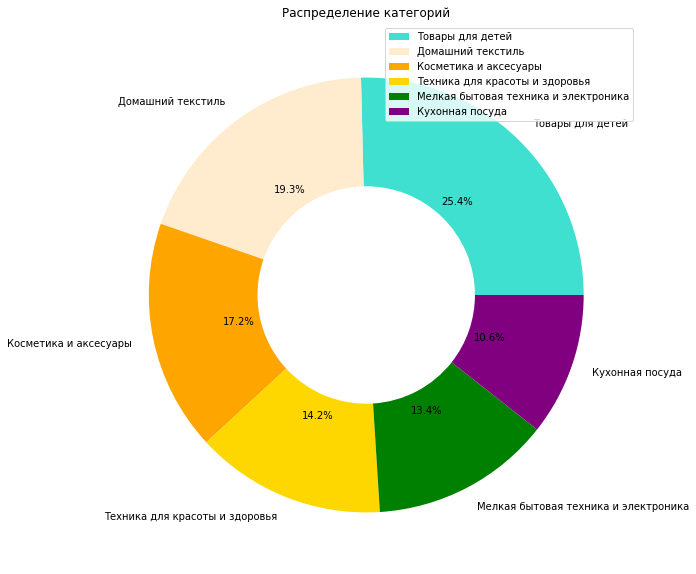

In [15]:
market_file['Популярная_категория'].value_counts().plot(
    kind='pie',
    figsize=(10, 10),
    autopct='%1.1f%%',
    title='Распределение категорий',
    ylabel='',
    wedgeprops={'width': 0.5},
    colors=['#40E0D0', '#FFEBCD', '#FFA500', '#FFD700', '#008000', '#800080']);

plt.legend()
plt.show()

Самой популярной категорией в магазине является 'Товары для детей' - 25.4%, самой нераспространенной категорией явлется 'Кухонная посуда' - 10.6%, также есть такие категории как 'Домашний текстиль', 'Косметика и аксесуары', 'Техника для красоты и здоровья', 'Мелкая бытовая техника и электроника'

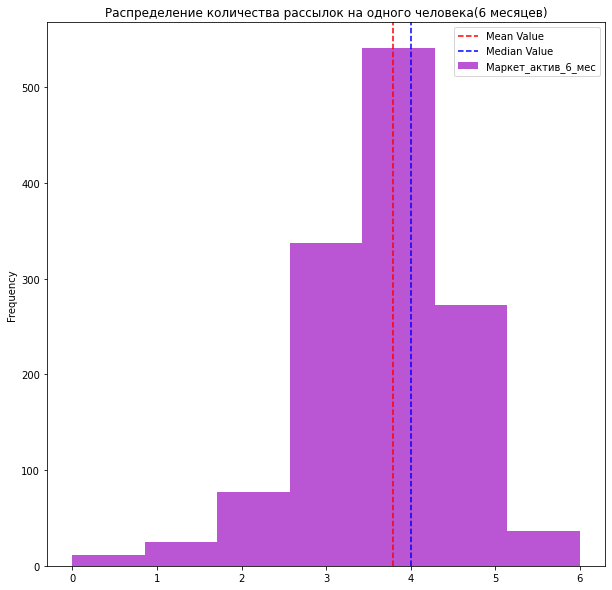

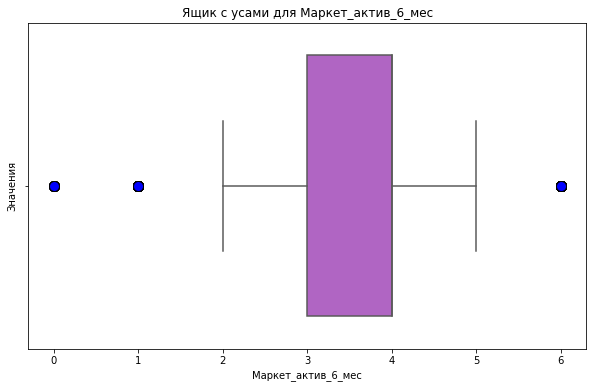

In [16]:
market_file['Маркет_актив_6_мес'].plot(
    kind='hist',
    bins=7,
    title='Распределение количества рассылок на одного человека(6 месяцев)',
    xlabel='Количество рассылок',
    ylabel='Количество человек',
    figsize=(10, 10),
    color='#BA55D3');

plt.axvline(x=market_file['Маркет_актив_6_мес'].mean(), color='red', linestyle='--', label='Mean Value')
plt.axvline(x=market_file['Маркет_актив_6_мес'].median(), color='blue', linestyle='--', label='Median Value')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='Маркет_актив_6_мес', 
            data=market_file, 
            ax=ax, 
            palette=['#BA55D3'],
               flierprops={'marker': 
                           'o', 
                           'markersize': 10, 
                           'markerfacecolor': 'blue', 
                           'markeredgecolor': 'black'})
plt.title('Ящик с усами для Маркет_актив_6_мес')
plt.xlabel('Маркет_актив_6_мес')
plt.ylabel('Значения')
plt.show()

Среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев варьируется от 1 до 6, чаще всего отправляется по 4 рассылки в месяц, распределение нормальное

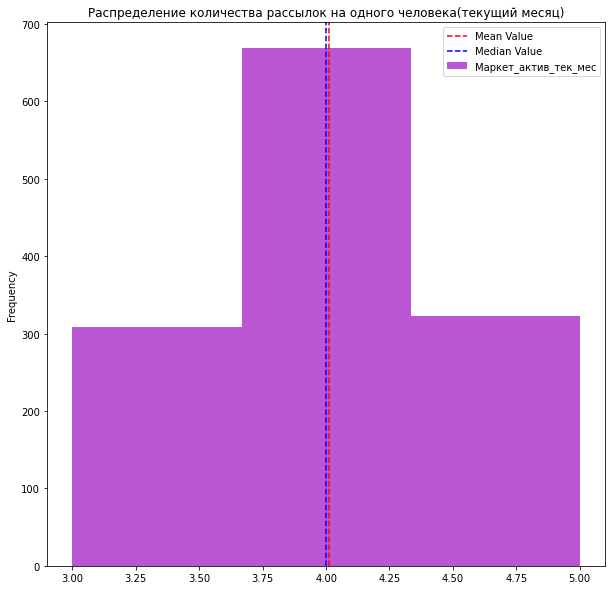

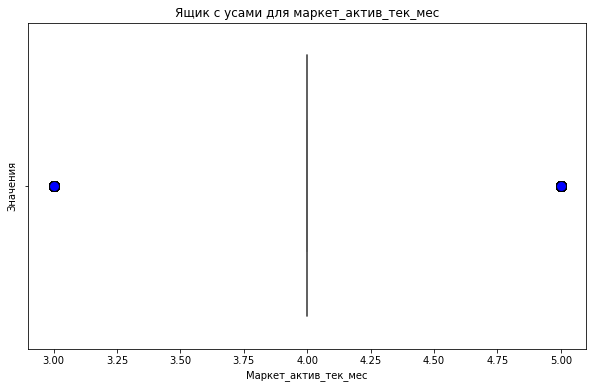

In [17]:
market_file['Маркет_актив_тек_мес'].plot(
    kind='hist',
    bins=3,
    title='Распределение количества рассылок на одного человека(текущий месяц)',
    xlabel='Количество рассылок',
    ylabel='Количество человек',
    figsize=(10, 10),
    color='#BA55D3');

plt.axvline(x=market_file['Маркет_актив_тек_мес'].mean(), color='red', linestyle='--', label='Mean Value')
plt.axvline(x=market_file['Маркет_актив_тек_мес'].median(), color='blue', linestyle='--', label='Median Value')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='Маркет_актив_тек_мес', 
            data=market_file, 
            ax=ax, 
            palette=['#BA55D3'],
               flierprops={'marker': 
                           'o', 
                           'markersize': 10, 
                           'markerfacecolor': 'blue', 
                           'markeredgecolor': 'black'})
plt.title('Ящик с усами для маркет_актив_тек_мес')
plt.xlabel('Маркет_актив_тек_мес')
plt.ylabel('Значения')
plt.show()

В месяц отправляется от 3 до 5 различных рассылок на клиента, в среднем 4 рассылки в месяц, распределение нормальное

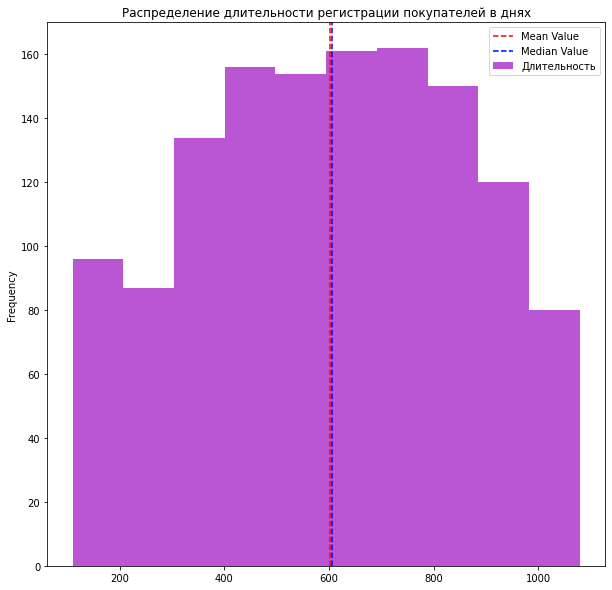

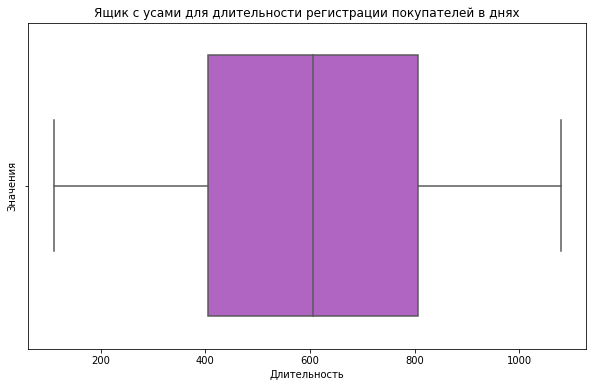

In [18]:
market_file['Длительность'].plot(
    kind='hist',
    title='Распределение длительности регистрации покупателей в днях',
    xlabel='Количество дней',
    ylabel='Количество человек',
    figsize=(10, 10),
    color='#BA55D3');

plt.axvline(x=market_file['Длительность'].mean(), color='red', linestyle='--', label='Mean Value')
plt.axvline(x=market_file['Длительность'].median(), color='blue', linestyle='--', label='Median Value')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='Длительность', 
            data=market_file, 
            ax=ax, 
            palette=['#BA55D3'],
               flierprops={'marker': 
                           'o', 
                           'markersize': 10, 
                           'markerfacecolor': 'blue', 
                           'markeredgecolor': 'black'})
plt.title('Ящик с усами для длительности регистрации покупателей в днях')
plt.xlabel('Длительность')
plt.ylabel('Значения')
plt.show()

Длительность регистрации покупателей варьируется примерно от 100 дней до 1200, в среднем пользователи зарегестрированы 600 дней, распределение нормальное

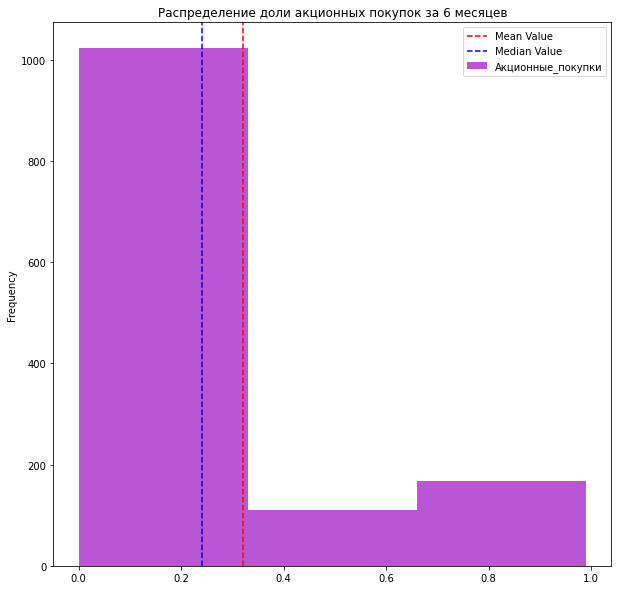

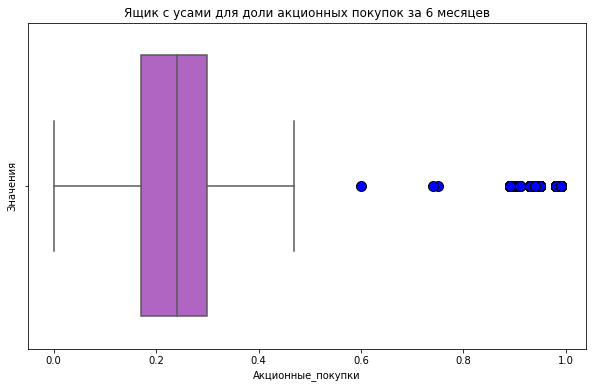

In [19]:
market_file['Акционные_покупки'].plot(
    kind='hist',
    bins=3,
    title='Распределение доли акционных покупок за 6 месяцев',
    xlabel='Доля акционных покупок',
    ylabel='Количество человек',
    figsize=(10, 10),
    color='#BA55D3');

plt.axvline(x=market_file['Акционные_покупки'].mean(), color='red', linestyle='--', label='Mean Value')
plt.axvline(x=market_file['Акционные_покупки'].median(), color='blue', linestyle='--', label='Median Value')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='Акционные_покупки', 
            data=market_file, 
            ax=ax, 
            palette=['#BA55D3'],
               flierprops={'marker': 
                           'o', 
                           'markersize': 10, 
                           'markerfacecolor': 'blue', 
                           'markeredgecolor': 'black'})
plt.title('Ящик с усами для доли акционных покупок за 6 месяцев')
plt.xlabel('Акционные_покупки')
plt.ylabel('Значения')
plt.show()

Среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев варбируется от 0 до 1, в среднем составляется примерно 0.3, распределение асимметричное вправо, как-то исправлять данные, думаю нет смысла, они отражают поведение людей

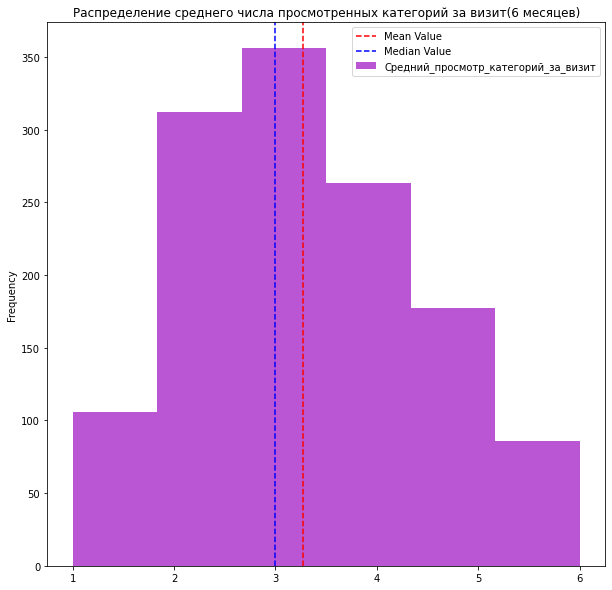

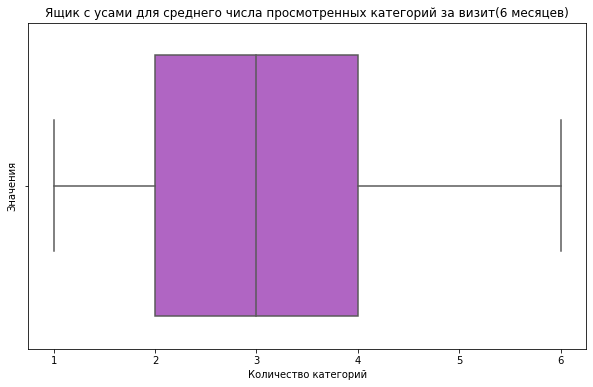

In [20]:
market_file['Средний_просмотр_категорий_за_визит'].plot(
    kind='hist',
    bins=6,
    title='Распределение среднего числа просмотренных категорий за визит(6 месяцев)',
    xlabel='Среднее число просмотренных категорий',
    ylabel='Количество человек',
    figsize=(10, 10),
    color='#BA55D3');

plt.axvline(x=market_file['Средний_просмотр_категорий_за_визит'].mean(), color='red', linestyle='--', label='Mean Value')
plt.axvline(x=market_file['Средний_просмотр_категорий_за_визит'].median(), color='blue', linestyle='--', label='Median Value')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='Средний_просмотр_категорий_за_визит', 
            data=market_file, 
            ax=ax, 
            palette=['#BA55D3'],
               flierprops={'marker': 
                           'o', 
                           'markersize': 10, 
                           'markerfacecolor': 'blue', 
                           'markeredgecolor': 'black'})
plt.title('Ящик с усами для среднего числа просмотренных категорий за визит(6 месяцев)')
plt.xlabel('Количество категорий')
plt.ylabel('Значения')
plt.show()

Распределение среднего числа просмотренных категорий за визит за последние пол года варьируется от 1 до 6, в среднем покупатель просматривает 3 категории за визит, распределение нормальное

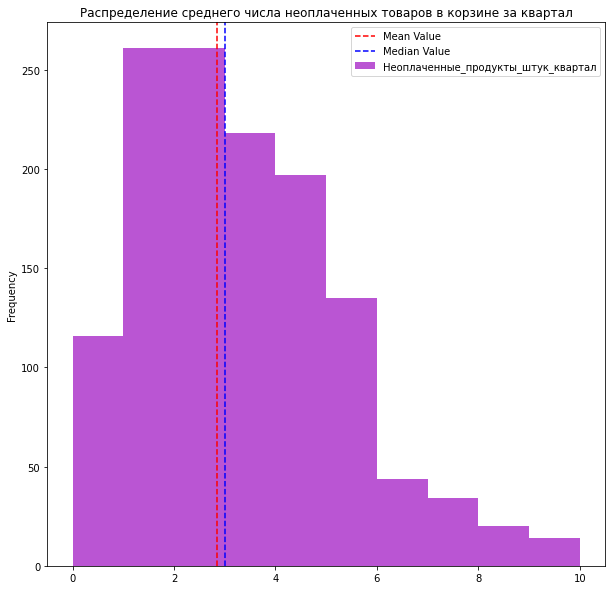

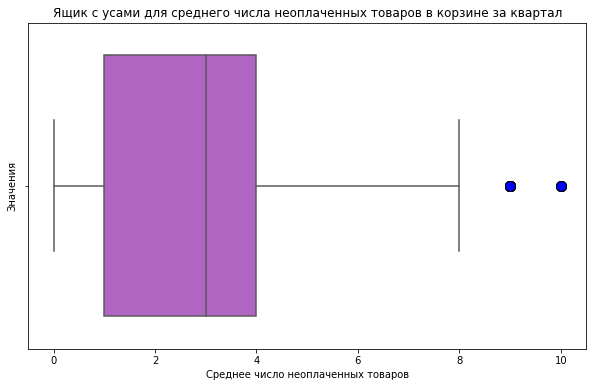

In [21]:
market_file['Неоплаченные_продукты_штук_квартал'].plot(
    kind='hist',
    title='Распределение среднего числа неоплаченных товаров в корзине за квартал',
    xlabel='Среднее число неоплаченных товаров',
    ylabel='Количество человек',
    figsize=(10, 10),
    color='#BA55D3');

plt.axvline(x=market_file['Неоплаченные_продукты_штук_квартал'].mean(), color='red', linestyle='--', label='Mean Value')
plt.axvline(x=market_file['Неоплаченные_продукты_штук_квартал'].median(), color='blue', linestyle='--', label='Median Value')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='Неоплаченные_продукты_штук_квартал', 
            data=market_file, 
            ax=ax, 
            palette=['#BA55D3'],
               flierprops={'marker':
                           'o',
                           'markersize': 10, 
                           'markerfacecolor': 'blue', 
                           'markeredgecolor': 'black'})
plt.title('Ящик с усами для среднего числа неоплаченных товаров в корзине за квартал')
plt.xlabel('Среднее число неоплаченных товаров')
plt.ylabel('Значения')
plt.show()

Распределение среднего числа неоплаченных товаров в корзине за квартал варьируется от 0 до 10, в среднем оно равно 3, распредление асимметричное вправо, исправлять данные не буду, они также отражают поведение людей

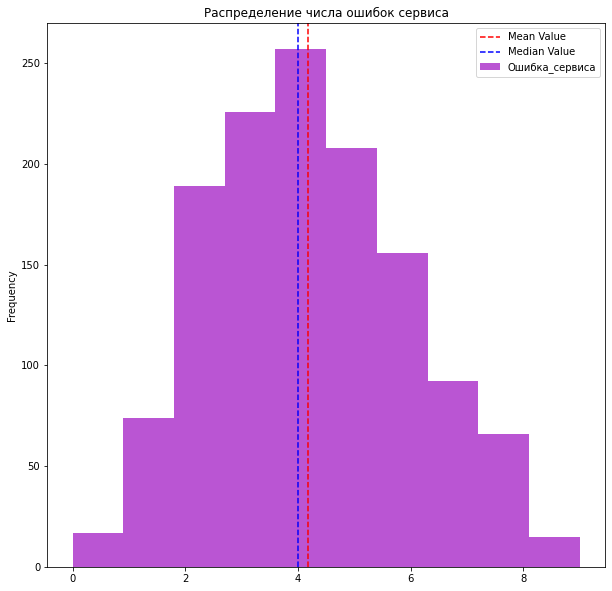

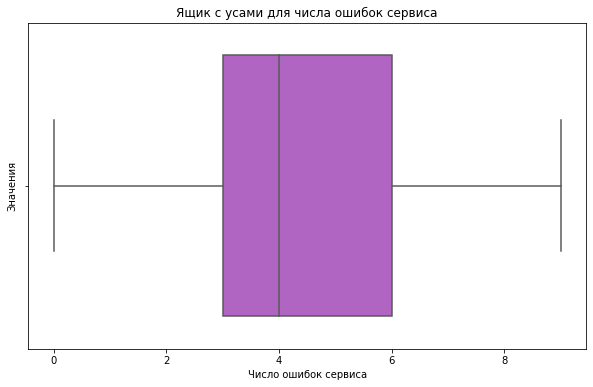

In [22]:
market_file['Ошибка_сервиса'].plot(
    kind='hist',
    title='Распределение числа ошибок сервиса',
    xlabel='Число ошибок сервиса',
    ylabel='Количество человек',
    figsize=(10, 10),
    color='#BA55D3');

plt.axvline(x=market_file['Ошибка_сервиса'].mean(), color='red', linestyle='--', label='Mean Value')
plt.axvline(x=market_file['Ошибка_сервиса'].median(), color='blue', linestyle='--', label='Median Value')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='Ошибка_сервиса', 
            data=market_file, 
            ax=ax, 
            palette=['#BA55D3'],
               flierprops={'marker':
                           'o',
                           'markersize': 10, 
                           'markerfacecolor': 'blue', 
                           'markeredgecolor': 'black'})
plt.title('Ящик с усами для числа ошибок сервиса')
plt.xlabel('Число ошибок сервиса')
plt.ylabel('Значения')
plt.show()

Число сбоев, которые коснулись покупателя во время посещения сайта варьируется от 0 до 8, в среднем у покупателя 4 сбоя во время нахождения на сайте, это очень много, распределение нормальное

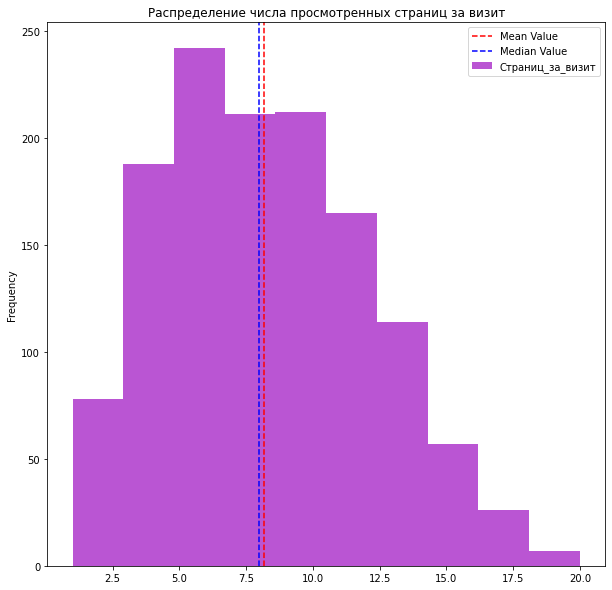

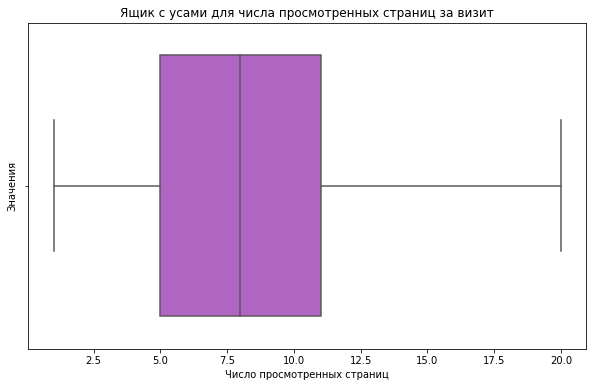

In [23]:
market_file['Страниц_за_визит'].plot(
    kind='hist',
    title='Распределение числа просмотренных страниц за визит',
    xlabel='Число просмотренных страниц',
    ylabel='Количество человек',
    figsize=(10, 10),
    color='#BA55D3');

plt.axvline(x=market_file['Страниц_за_визит'].mean(), color='red', linestyle='--', label='Mean Value')
plt.axvline(x=market_file['Страниц_за_визит'].median(), color='blue', linestyle='--', label='Median Value')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='Страниц_за_визит', 
            data=market_file, 
            ax=ax, 
            palette=['#BA55D3'],
               flierprops={'marker':
                           'o',
                           'markersize': 10, 
                           'markerfacecolor': 'blue', 
                           'markeredgecolor': 'black'})
plt.title('Ящик с усами для числа просмотренных страниц за визит')
plt.xlabel('Число просмотренных страниц')
plt.ylabel('Значения')
plt.show()

Среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца варьируется от 2 до 20, В среднем покупатель просматривает 8 страниц, распределение нормальное

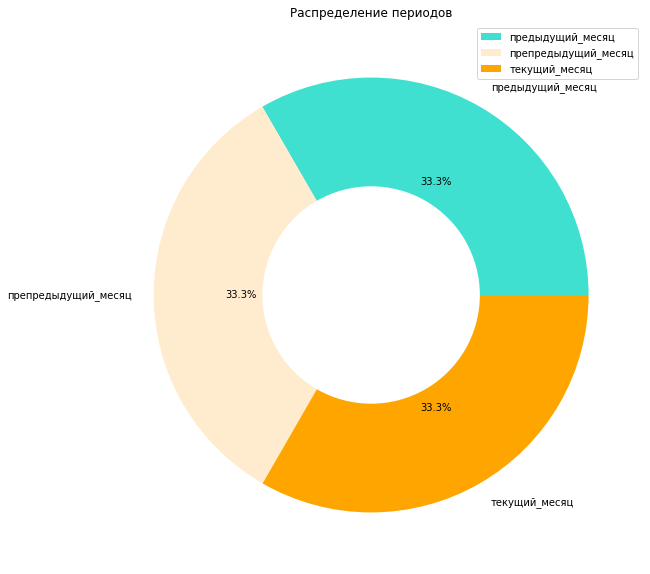

In [24]:
market_money['Период'].value_counts().plot(
    kind='pie',
    figsize=(10, 10),
    autopct='%1.1f%%',
    title='Распределение периодов',
    ylabel='',
    wedgeprops={'width': 0.5},
    colors=['#40E0D0', '#FFEBCD', '#FFA500']);

plt.legend()
plt.show()

Все периоды распределены одинаково 

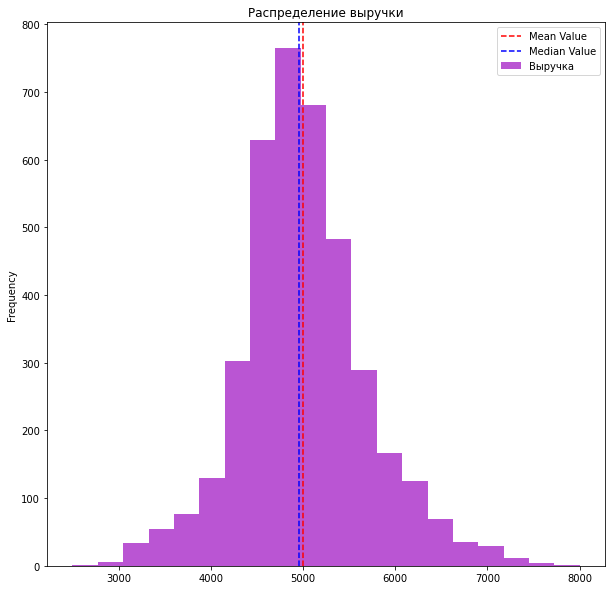

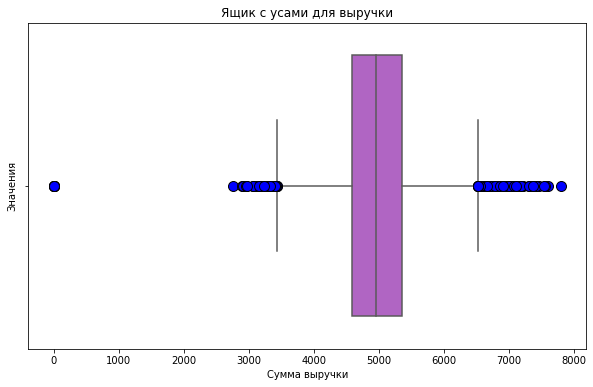

In [25]:
market_money['Выручка'].plot(
    kind='hist',
    bins=20,
    range=(2500, 8000),
    title='Распределение выручки',
    xlabel='Сумма выручки',
    ylabel='Количество человек',
    figsize=(10, 10),
    color='#BA55D3');

plt.axvline(x=market_money['Выручка'].mean(), color='red', linestyle='--', label='Mean Value')
plt.axvline(x=market_money['Выручка'].median(), color='blue', linestyle='--', label='Median Value')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='Выручка', 
            data=market_money, 
            ax=ax, 
            palette=['#BA55D3'],
            flierprops={'marker':
                        'o',
                        'markersize': 10, 
                        'markerfacecolor': 'blue', 
                        'markeredgecolor': 'black'})
plt.title('Ящик с усами для выручки')
plt.xlabel('Сумма выручки')
plt.ylabel('Значения')
plt.show()

Распределение выручки с покупателя в среднем равен 5000 рублей, распределение нормальное

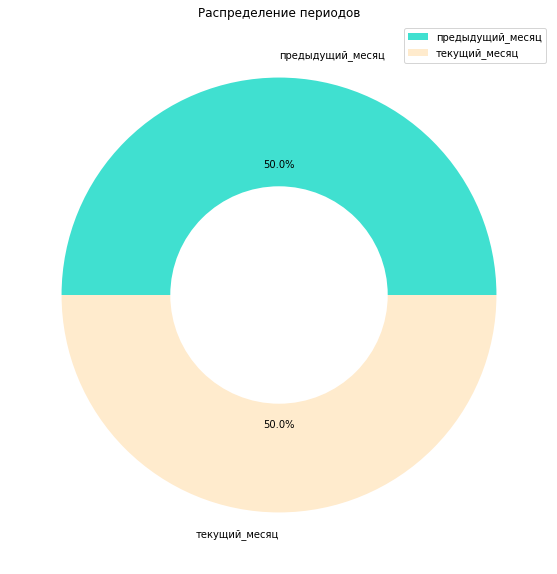

In [26]:
market_time['Период'].value_counts().plot(
    kind='pie',
    figsize=(10, 10),
    autopct='%1.1f%%',
    title='Распределение периодов',
    ylabel='',
    wedgeprops={'width': 0.5},
    colors=['#40E0D0', '#FFEBCD', '#FFA500']);

plt.legend()
plt.show()

Периоды распределены одинаково

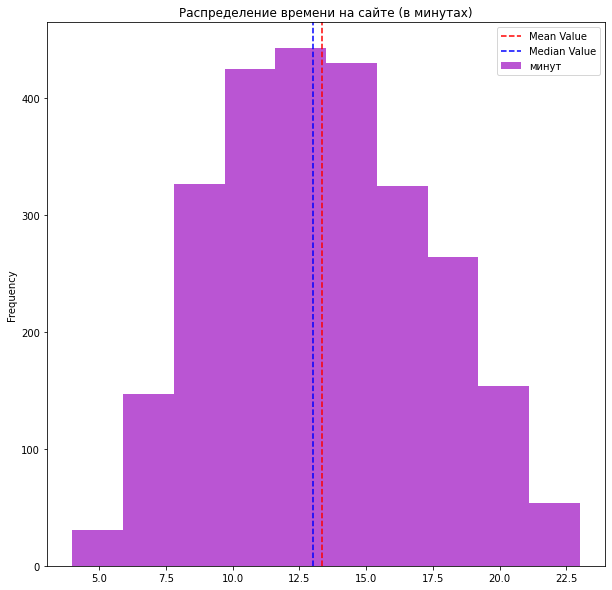

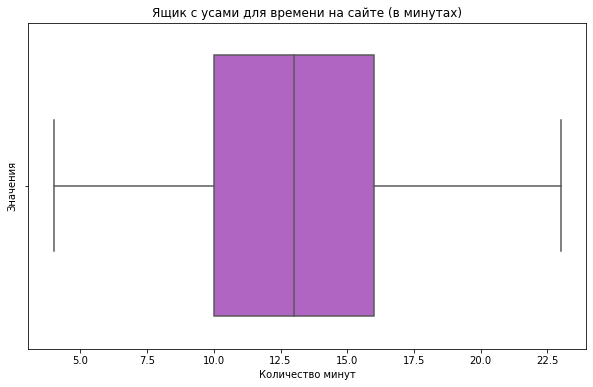

In [27]:
market_time['минут'].plot(
    kind='hist',
    title='Распределение времени на сайте (в минутах)',
    xlabel='Количество минут',
    ylabel='Количество человек',
    figsize=(10, 10),
    color='#BA55D3');

plt.axvline(x=market_time['минут'].mean(), color='red', linestyle='--', label='Mean Value')
plt.axvline(x=market_time['минут'].median(), color='blue', linestyle='--', label='Median Value')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='минут', 
            data=market_time, 
            ax=ax, 
            palette=['#BA55D3'],
            flierprops={'marker':
                        'o',
                        'markersize': 10, 
                        'markerfacecolor': 'blue', 
                        'markeredgecolor': 'black'})
plt.title('Ящик с усами для времени на сайте (в минутах)')
plt.xlabel('Количество минут')
plt.ylabel('Значения')
plt.show()

Значение времени, проведённого на сайте, в минутах в среднем равно 13 минутам, распределение нормальное

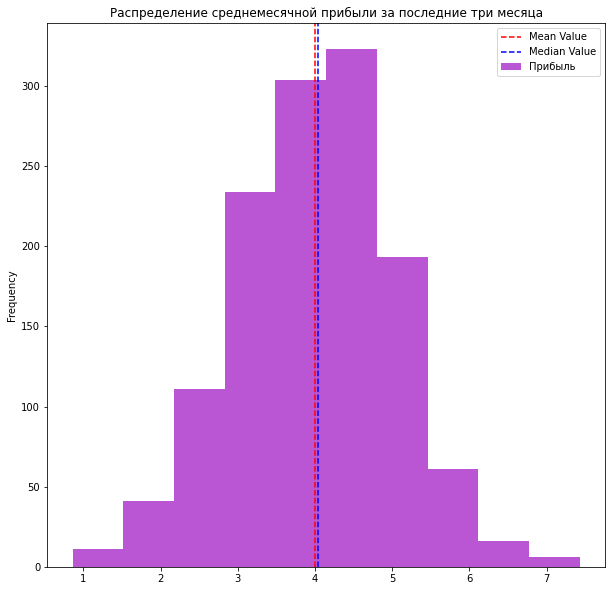

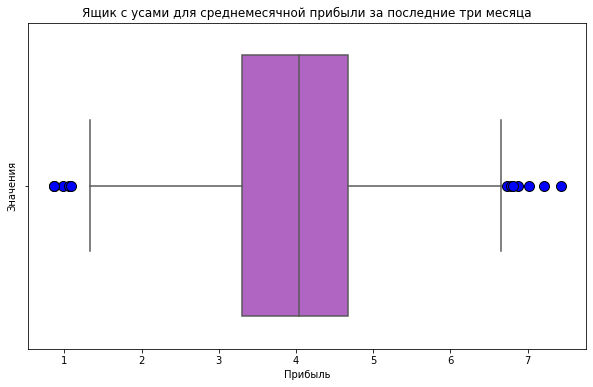

In [28]:
money['Прибыль'].plot(
    kind='hist',
    title='Распределение среднемесячной прибыли за последние три месяца',
    xlabel='Прибыль',
    ylabel='Количество человек',
    figsize=(10, 10),
    color='#BA55D3');

plt.axvline(x=money['Прибыль'].mean(), color='red', linestyle='--', label='Mean Value')
plt.axvline(x=money['Прибыль'].median(), color='blue', linestyle='--', label='Median Value')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(x='Прибыль', 
            data=money, 
            ax=ax, 
            palette=['#BA55D3'],
            flierprops={'marker':
                        'o',
                        'markersize': 10, 
                        'markerfacecolor': 'blue', 
                        'markeredgecolor': 'black'})
plt.title('Ящик с усами для среднемесячной прибыли за последние три месяца')
plt.xlabel('Прибыль')
plt.ylabel('Значения')
plt.show()

В среднем с покупателя в месяц магазин получает 4 тысячи рублей, распределение нормальное

In [29]:
market_file = market_file.drop([215357, 215348, 215359], axis=0)
market_money = market_money.drop([215357, 215348, 215359], axis=0)
market_time = market_time.drop([215357, 215348, 215359], axis=0)
money = money.drop([215357, 215348, 215359], axis=0)

Обнаружилось всего три покупателя с активностью менее трех месяцев, удалены во всех датасетах

Данные выглядят хорошо, выбросы удалены и данные подправлены, все это исправил в предобработке

Распределения отличные от нормального:

    В датасете market_file:

        -Доля акционных покупок за 6 месяцев
        -Среднее число неоплаченных товаров в корзине за квартал

Менять значение не буду, в них нет выбросов, с помощью них можно определить поведения покупателей

## Объединение таблиц

In [30]:
market_money_pivot = pd.pivot_table(market_money, values='Выручка', index='id', columns='Период')
market_money_pivot.columns = ['Выручка_' + col for col in market_money_pivot.columns]

market_time_pivot = pd.pivot_table(market_time, values='минут', index='id', columns='Период')
market_time_pivot.columns = ['Минуты_' + col for col in market_time_pivot.columns]

market_file = pd.merge(market_file, market_money_pivot, on='id')
market_file = pd.merge(market_file, market_time_pivot, on='id')

In [31]:
display(market_file.sample(10))

,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Выручка_текущий_месяц,Минуты_предыдущий_месяц,Минуты_текущий_месяц
id,,,,,,,,,,,,,,,,,
215518,Снизилась,премиум,да,3,5,744,0.28,Товары для детей,3,2,2,6,4987.0,4156.0,5237.9,6,6
215935,Снизилась,стандарт,да,5,4,352,0.13,Товары для детей,1,7,3,10,5371.5,5274.0,5586.0,15,19
215564,Снизилась,стандарт,нет,3,3,618,0.24,Техника для красоты и здоровья,2,10,3,5,2890.0,4213.0,3334.6,12,12
216086,Прежний уровень,стандарт,нет,4,3,494,0.25,Косметика и аксесуары,2,3,4,4,4755.5,4667.0,4962.2,16,15
215780,Прежний уровень,премиум,да,4,3,728,0.28,Косметика и аксесуары,4,1,2,5,5404.5,4950.0,5928.4,12,21
216038,Прежний уровень,премиум,нет,4,5,179,0.26,Товары для детей,3,2,2,12,4930.0,5123.0,5227.7,18,11
215706,Снизилась,стандарт,да,3,5,730,0.94,Товары для детей,2,3,7,6,4762.0,4435.0,5066.2,10,13
215850,Прежний уровень,стандарт,да,5,4,267,0.15,Техника для красоты и здоровья,5,1,1,7,4009.0,4783.0,4809.8,19,16
215877,Прежний уровень,стандарт,да,4,4,349,0.17,Мелкая бытовая техника и электроника,6,5,4,9,4324.5,4665.0,4159.4,16,19


Таблицы объединены в одну - market_file, новые столбцы в датасете - 'Выручка_предыдущий_месяц', 'Выручка_препредыдущий_месяц', 'Минуты_предыдущий_месяц', 'Минуты_текущий_месяц', 'Выручка_текущий_месяц'

## Корреляционный анализ

interval columns not set, guessing: ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'Выручка_предыдущий_месяц', 'Выручка_препредыдущий_месяц', 'Минуты_предыдущий_месяц', 'Минуты_текущий_месяц']


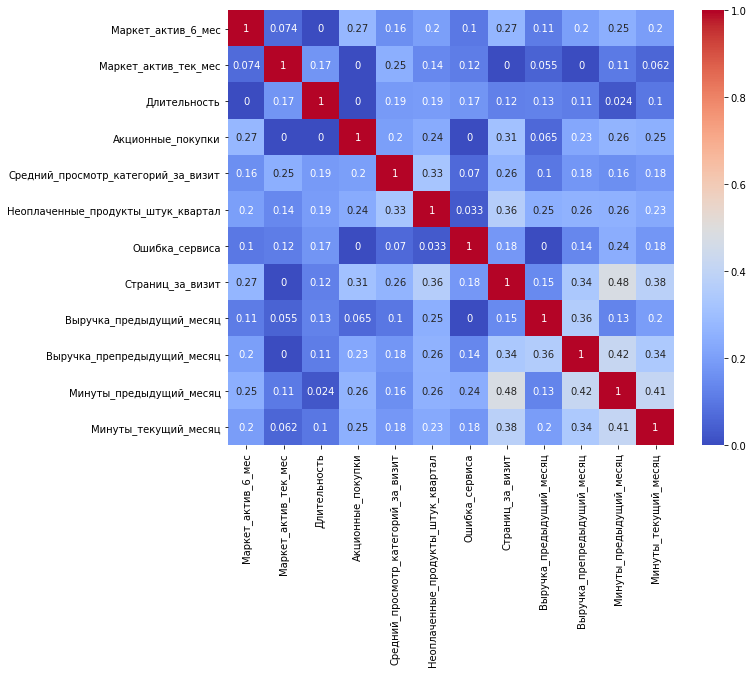

In [32]:
plt.figure(figsize=(10, 8))
sns.heatmap(phik_matrix(market_file[[
    'Маркет_актив_6_мес', 
    'Маркет_актив_тек_мес', 
    'Длительность', 
    'Акционные_покупки', 
    'Средний_просмотр_категорий_за_визит',
    'Неоплаченные_продукты_штук_квартал',
    'Ошибка_сервиса',
    'Страниц_за_визит',
    'Выручка_предыдущий_месяц',
    'Выручка_препредыдущий_месяц',
    'Минуты_предыдущий_месяц',
    'Минуты_текущий_месяц'
]]), annot=True, cmap='coolwarm')
plt.show()

Высокая корреляция между 'Выручка_текущий_месяц' и 'Выручка_предыдущий_месяц', решил убрать столбец 'Выручка_текущий_месяц', так как информация в нем может быть неполной и лучше знать значение выручки за прошлый месяц, потому что, если это первый день текущего месяца, то информация из столбца 'Выручка_текущий_месяц' ничего не даст

In [33]:
market_file = market_file.drop('Выручка_текущий_месяц', axis=1)

interval columns not set, guessing: ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'Выручка_предыдущий_месяц', 'Выручка_препредыдущий_месяц', 'Минуты_предыдущий_месяц', 'Минуты_текущий_месяц']


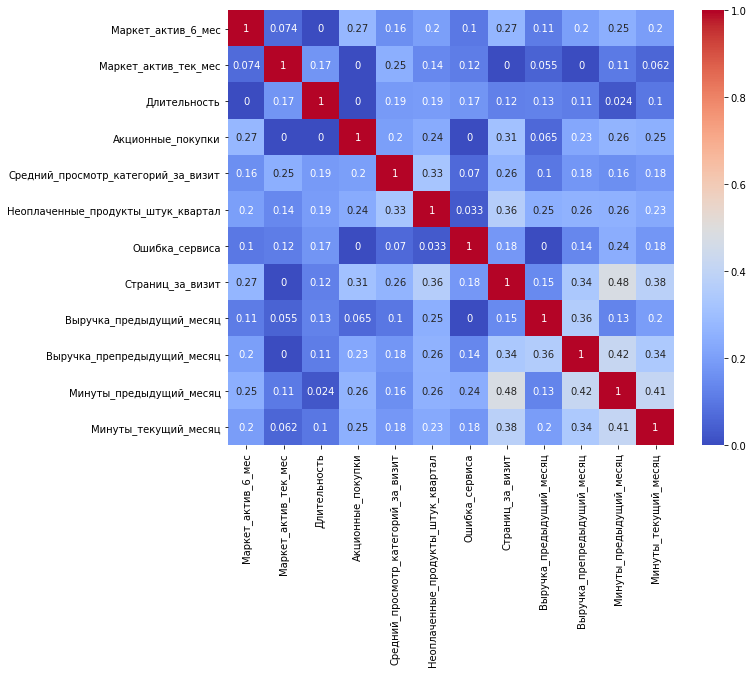

In [34]:
plt.figure(figsize=(10, 8))
sns.heatmap(phik_matrix(market_file[[
    'Маркет_актив_6_мес', 
    'Маркет_актив_тек_мес', 
    'Длительность', 
    'Акционные_покупки', 
    'Средний_просмотр_категорий_за_визит',
    'Неоплаченные_продукты_штук_квартал',
    'Ошибка_сервиса',
    'Страниц_за_визит',
    'Выручка_предыдущий_месяц',
    'Выручка_препредыдущий_месяц',
    'Минуты_предыдущий_месяц',
    'Минуты_текущий_месяц'
]]), annot=True, cmap='coolwarm')
plt.show()

Наблюдалась мультиколлинеарность между признаками 'Выручка_текущий_месяц' и 'Выручка_предыдущий_месяц', исправил ее, удалив признак 'Выручка_текущий_месяц', теперь в данных мультиколлинеарности нет

## Использование пайплайнов

In [35]:
market_file.loc[market_file['Покупательская_активность'] == 'Прежний уровень', 'Покупательская_активность'] = 0
market_file.loc[market_file['Покупательская_активность'] == 'Снизилась', 'Покупательская_активность'] = 1
market_file['Покупательская_активность'] = market_file['Покупательская_активность'].astype(float)

Приведу целевой признак к типу float где 0 - покупательская активность осталась на прежнем уровне, а 1 - снизилась

In [36]:
X = market_file.drop('Покупательская_активность', axis=1)
y = market_file['Покупательская_активность']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

In [55]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((972, 15), (325, 17), (972,), (325,))

In [39]:
ohe_columns = ['Разрешить_сообщать', 
               'Популярная_категория']

ord_columns = ['Тип_сервиса']

num_columns = ['Маркет_актив_6_мес', 
               'Маркет_актив_тек_мес', 
               'Длительность', 
               'Средний_просмотр_категорий_за_визит', 
               'Ошибка_сервиса', 
               'Выручка_предыдущий_месяц',
               'Выручка_препредыдущий_месяц',
               'Минуты_текущий_месяц',
               'Акционные_покупки', 
               'Неоплаченные_продукты_штук_квартал', 
               'Страниц_за_визит', 
               'Минуты_предыдущий_месяц']

In [40]:
# SimpleImputer + OHE

ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse=False))
    ]
)

In [41]:
display(market_file['Тип_сервиса'].unique())

array(['премиум', 'стандарт'], dtype=object)

In [42]:
# SimpleImputer + OE

ord_pipe = Pipeline(
    [
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('oe', OrdinalEncoder(
            categories=[
                ['стандарт', 'премиум']
            ],
            handle_unknown='use_encoded_value', unknown_value=np.nan
        )),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [43]:
# общий пайплайн для подготовки данных

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [44]:
# итоговый пайплайн: подготовка данных и модель

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [45]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 3),
        'models__max_features': range(2, 3),
        'preprocessor__num': [StandardScaler(), RobustScaler(), 'passthrough']
    },

    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 3),
        'preprocessor__num': [StandardScaler(), RobustScaler(), 'passthrough']
    },

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 3),
        'preprocessor__num': [StandardScaler(), RobustScaler(), 'passthrough']
    },

    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': range(1, 3),
        'models__degree': range(1, 5),
        'preprocessor__num': [StandardScaler(), RobustScaler(), 'passthrough']
    }
]

In [46]:
grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        sparse=False))]),
                                                                         ['Разрешить_сообщать',
                                                                          'Популярная_категория']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('simpleImputer_before_ord',...
                         {'models': [LogisticRegression(penalty='l1',
                                                        random_state=42,
                                                        solver='liblinear')],
                          'models__C': range(1, 3),
                          'preprocessor__num': [StandardScaler(),
                                                RobustScaler(),
                                                'passthrough']},
                         {'models': [SVC(C=1, degree=1, probability=True,
                                         random_state=42)],
                          'models__C': range(1, 3),
                          'models__degree': range(1, 5),
                          'preprocessor__num': [StandardScaler(),
                                                RobustScaler(),
                                                'passthrough']}],
             scoring='roc_auc')

In [47]:
print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid_search.best_score_.round(3))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Разрешить_сообщать',
                                                   'Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                   

In [48]:
y_test_proba = grid_search.predict_proba(X_test) 
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_proba[:,1]).round(3)}')

Метрика ROC-AUC на тестовой выборке: 0.922


Лучшей моделью оказалась SVC с параметрами C=1, degree=1, random_state=42, с метрикой ROC-AUC на тестовой выборке равной 0.922, что очень хорошо, в нашем случае классы несбалансированы поэтому метрика ROC-AUC будет здесь объективна

В этом проекте поставил маленькие переборы гипермараметров, чтобы проект выполнился быстрее, сначала писал код в пайчарме с большими переборами поэтому значения взял оттуда

## Анализ важности признаков

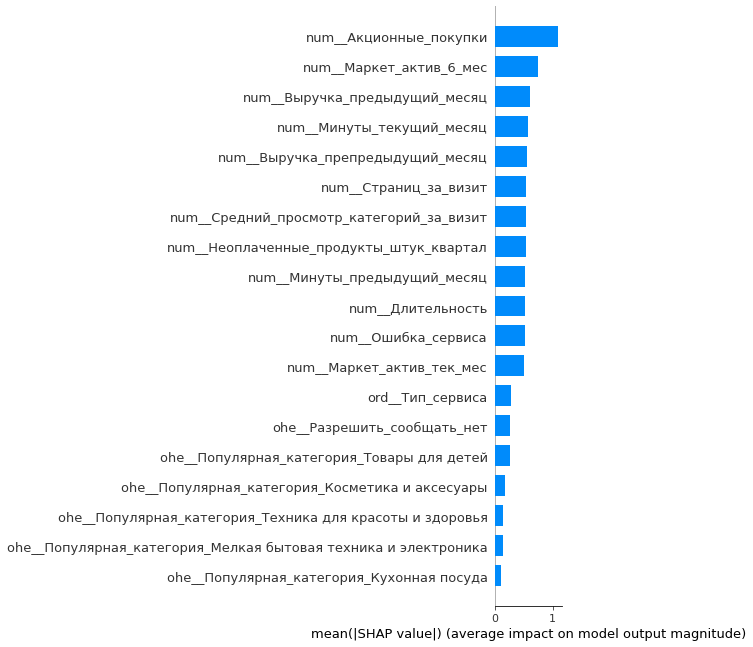

In [49]:
X_estim = grid_search.best_estimator_['preprocessor'].fit_transform(X_train)

best_model_fit = grid_search.best_estimator_['models'].fit(X_estim, y_train)
explainer_1 = shap.ExactExplainer(best_model_fit, X_estim)

feature_names_1 = grid_search.best_estimator_[:-1].get_feature_names_out()

shap.summary_plot(X_estim, plot_type='bar', feature_names=feature_names_1)

    Признаки, которые сильнее всего влияют на целевой признак:
    
        -Длительность
        -Минуты_предыдущий_месяц	
        -Страниц_за_визит
        -Средний_просмотр_категорий_за_визит
        -Минуты_текущий_месяц
        -Выручка_препредыдущий_месяц
        -Ошибка_сервиса
        -Неоплаченные_продукты_штук_квартал
        -Выручка_предыдущий_месяц
        -Маркет_актив_6_мес	
        -Маркет_актив_тек_мес	
        -Акционные_покупки
        
    Признаки, которые мало значимы для целевого признака:
    
        -Тип_сервиса
        -Все популярные категории
        
    Эти наблюдения можно использовать для оптимизации ресурсов и предсказания потенциальных покупателей.

## Сегментация покупателей

In [50]:
X_test['покупательская_активность_предсказание_снижение'] = y_test_proba[:, 1]
X_test['покупательская_активность_предсказание_прежняя'] = y_test_proba[:, 0]
display(X_test.sample(10))

,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Минуты_предыдущий_месяц,Минуты_текущий_месяц,покупательская_активность_предсказание_снижение,покупательская_активность_предсказание_прежняя
id,,,,,,,,,,,,,,,,,
215860,стандарт,да,5,5,242,0.21,Кухонная посуда,5,4,4,11,4204.5,4614.0,18,19,0.059018,0.940982
215893,стандарт,нет,4,4,639,0.13,Мелкая бытовая техника и электроника,2,4,2,10,4936.5,5016.0,22,14,0.151406,0.848594
215476,премиум,да,3,4,666,0.39,Кухонная посуда,3,3,2,2,5053.0,4243.0,6,11,0.999998,0.000002
216564,стандарт,да,5,4,342,0.94,Кухонная посуда,2,7,5,8,4930.0,5269.0,14,19,0.732125,0.267875
215705,премиум,нет,0,4,657,0.99,Домашний текстиль,2,4,2,5,5055.5,4568.0,10,7,0.969559,0.030441
215696,премиум,да,3,3,384,0.98,Кухонная посуда,1,9,4,3,5728.5,4779.0,16,11,0.918574,0.081426
216527,стандарт,нет,4,3,679,0.15,Техника для красоты и здоровья,4,1,1,14,4668.0,5023.0,12,19,0.042194,0.957806
216305,премиум,нет,4,4,508,0.14,Косметика и аксесуары,2,1,6,8,5621.0,4679.0,17,18,0.088365,0.911635
216119,премиум,да,4,3,208,0.13,Косметика и аксесуары,5,2,1,10,5004.0,5154.0,12,8,0.088479,0.911521


In [51]:
high_risk_down = X_test[(X_test['покупательская_активность_предсказание_снижение'] > 0.9) & 
                           ((X_test['Выручка_предыдущий_месяц'] + X_test['Выручка_препредыдущий_месяц']) > 10000)]

display(high_risk_down)

,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Минуты_предыдущий_месяц,Минуты_текущий_месяц,покупательская_активность_предсказание_снижение,покупательская_активность_предсказание_прежняя
id,,,,,,,,,,,,,,,,,
215578,стандарт,да,2,4,699,0.35,Мелкая бытовая техника и электроника,2,4,5,3,5328.5,4778.0,10,7,0.991956,0.008044
215483,стандарт,да,3,5,855,0.99,Кухонная посуда,2,6,7,6,6349.0,4834.0,8,8,0.956531,0.043469
215727,стандарт,да,4,4,598,0.39,Косметика и аксесуары,2,3,5,5,5421.5,4622.0,9,12,0.976188,0.023812
215401,премиум,да,3,5,339,0.30,Косметика и аксесуары,2,3,3,4,5548.5,4833.0,10,8,0.978796,0.021204
215376,стандарт,да,2,3,534,0.98,Домашний текстиль,4,1,5,4,6061.0,4723.0,8,9,0.945636,0.054364
215406,стандарт,да,2,5,511,0.30,Товары для детей,3,2,4,6,5715.5,4763.0,6,6,0.984752,0.015248
215599,стандарт,да,3,4,716,0.28,Домашний текстиль,2,9,4,6,6058.0,4546.0,12,8,0.985885,0.014115
215576,премиум,да,4,5,840,0.40,Косметика и аксесуары,3,1,5,5,5764.5,4500.0,8,9,0.989385,0.010615
215363,стандарт,нет,4,4,923,0.29,Товары для детей,6,0,3,1,6010.0,4633.0,8,5,0.972146,0.027854


    Анализ сегмента клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью:
    
        -Большинство согласно на рассылку от магазина со средней частотой 3 в месяц
        -Стандартный тип сервиса преобладает над премиумным
        -Часто совершают покупки по акции
        -Большинство покупок из категории 'Косметика и аксесуары', также часто 'Домашний текстиль' и 
        'Товары для детей'
        -Чаще всего от 3 до 5 ошибок на сайте
        -Обычно просматривают по 2 категории за визит

In [53]:
high_risk_same = X_test[(X_test['покупательская_активность_предсказание_прежняя'] > 0.9) & 
                           ((X_test['Выручка_предыдущий_месяц'] + X_test['Выручка_препредыдущий_месяц']) > 10000)]

display(high_risk_same)

,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_предыдущий_месяц,Выручка_препредыдущий_месяц,Минуты_предыдущий_месяц,Минуты_текущий_месяц,покупательская_активность_предсказание_снижение,покупательская_активность_предсказание_прежняя
id,,,,,,,,,,,,,,,,,
216301,премиум,да,3,5,410,0.20,Косметика и аксесуары,3,1,5,14,5052.5,5348.0,17,13,0.067059,0.932941
216533,стандарт,нет,5,5,769,0.14,Техника для красоты и здоровья,4,1,8,10,5868.0,4925.0,15,20,0.082717,0.917283
216219,премиум,да,4,3,784,0.23,Косметика и аксесуары,2,1,6,6,5198.5,5614.0,13,20,0.070037,0.929963
216218,стандарт,да,5,4,345,0.12,Техника для красоты и здоровья,5,3,3,9,5378.5,5317.0,7,12,0.064280,0.935720
216193,стандарт,да,3,4,191,0.19,Товары для детей,4,4,5,13,5440.0,5080.0,14,7,0.060748,0.939252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215782,стандарт,да,5,3,457,0.17,Товары для детей,4,1,5,5,5597.0,5624.0,12,10,0.059527,0.940473
216087,стандарт,нет,5,4,166,0.31,Товары для детей,5,1,5,9,5140.0,4926.0,14,13,0.063889,0.936111
216412,стандарт,да,5,3,847,0.11,Мелкая бытовая техника и электроника,5,1,5,4,5227.0,5233.0,14,16,0.023803,0.976197


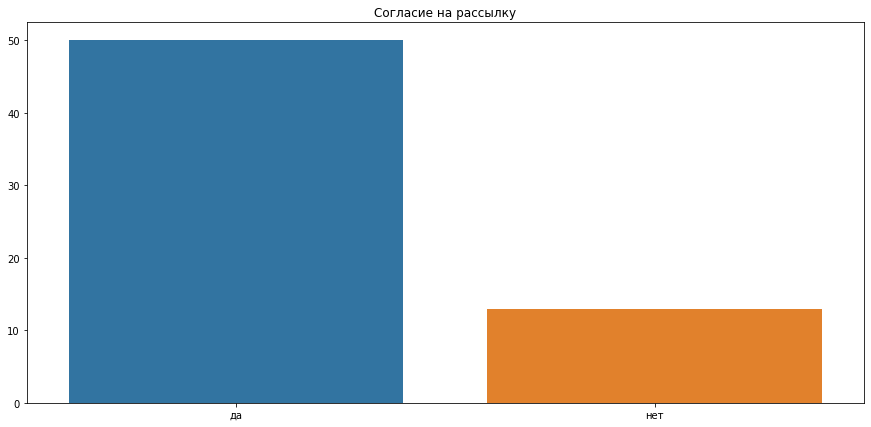

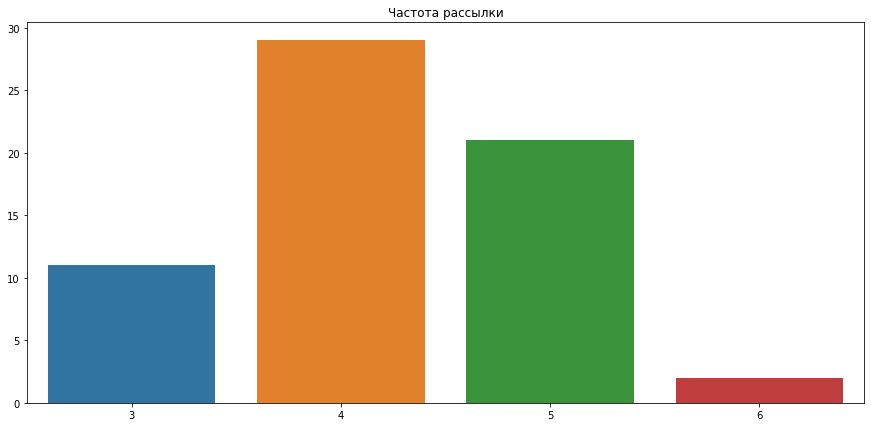

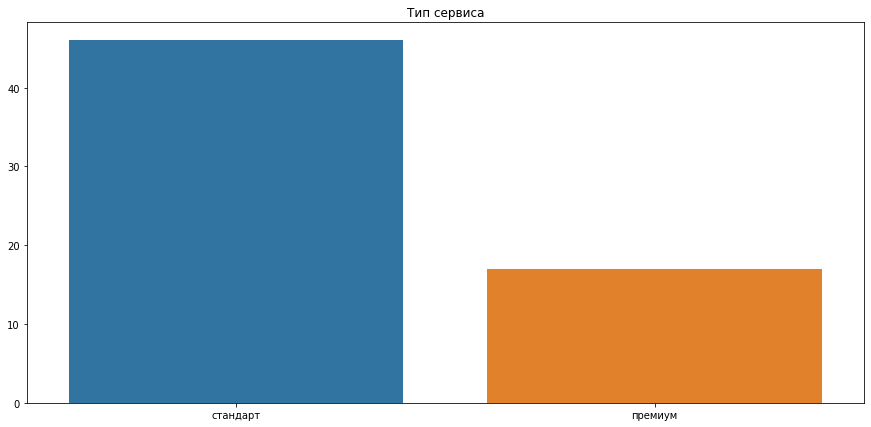

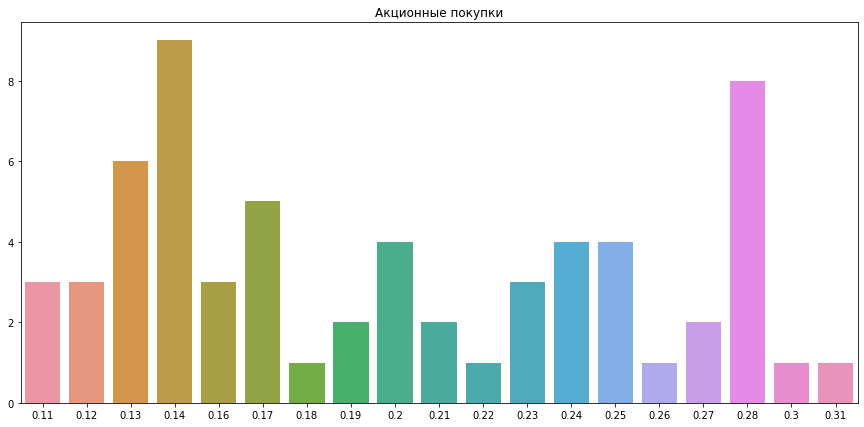

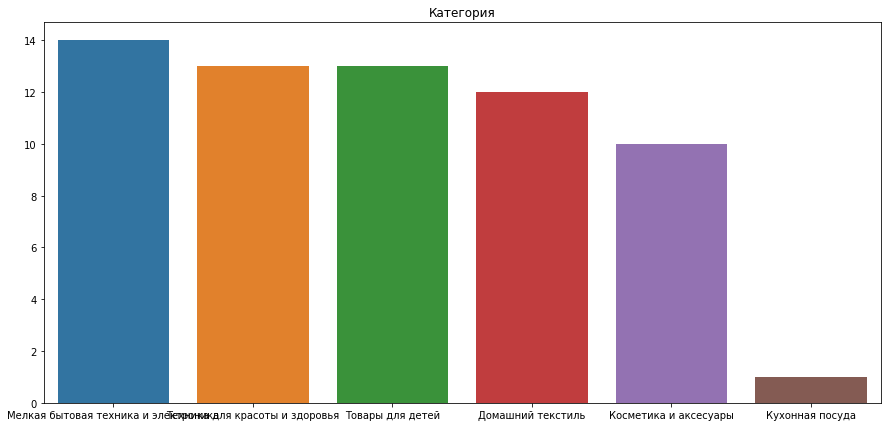

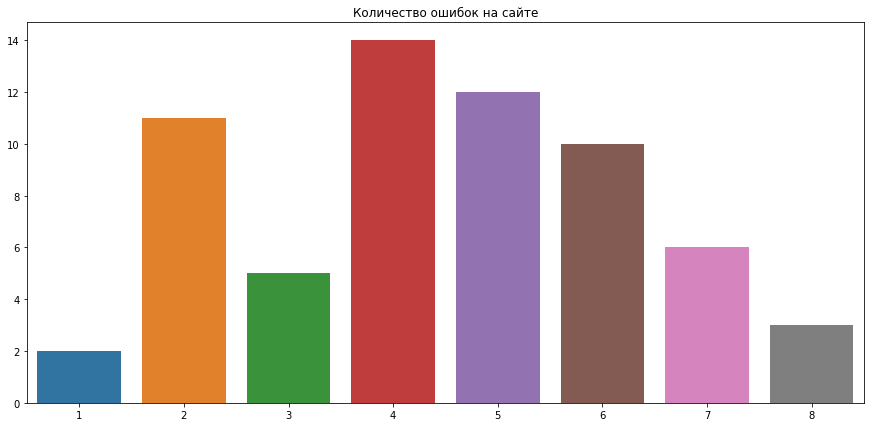

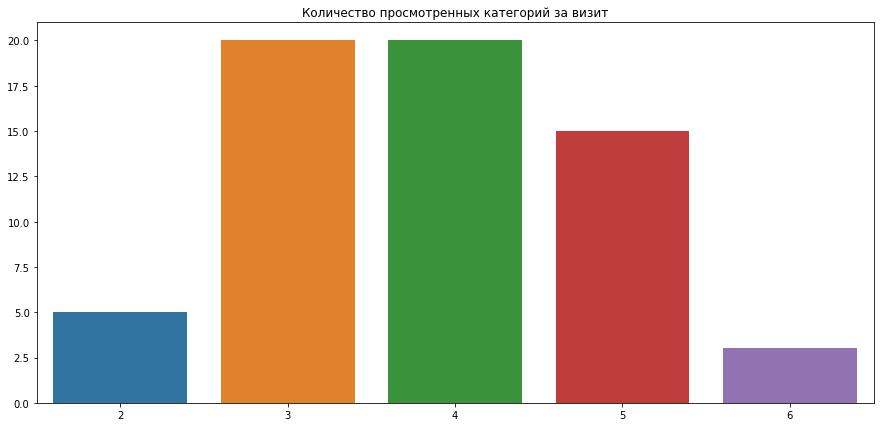

In [54]:
def plot_segment_data(segment_data, column_name, title):
    plt.figure(figsize=(15, 7))
    column_values = segment_data[column_name].value_counts()
    sns.barplot(x=column_values.index, y=column_values.values)
    plt.title(title)
    plt.show()
    
    
plot_segment_data(high_risk_same, 'Разрешить_сообщать', 'Согласие на рассылку')
plot_segment_data(high_risk_same, 'Маркет_актив_6_мес', 'Частота рассылки')
plot_segment_data(high_risk_same, 'Тип_сервиса', 'Тип сервиса')
plot_segment_data(high_risk_same, 'Акционные_покупки', 'Акционные покупки')
plot_segment_data(high_risk_same, 'Популярная_категория', 'Категория')
plot_segment_data(high_risk_same, 'Ошибка_сервиса', 'Количество ошибок на сайте')
plot_segment_data(high_risk_same, 'Средний_просмотр_категорий_за_визит', 'Количество просмотренных категорий за визит')

    Анализ сегмента клиентов с низкой вероятностью снижения покупательской активности и наиболее высокой прибыльностью:
    
        -Большинство согласно на рассылку от магазина со средней частотой 4 в месяц
        -Стандартный тип сервиса преобладает над премиумным
        -Редко совершают покупки по акции
        -Большинство покупок из категории 'Мелкая бытовая техника и электроника', также часто 
        'Техника для красоты и здоровья', 'Товары для детей' и 'Домашний текстиль'
        -Чаще всего от 2 до 5 ошибок на сайте
        -Обычно просматривают по 4 категории за визит

Исходя из анализа, можно сказать, что высокая вероятность снижения покупательской активности у людей, которые покупают по скидке и просматривают мало категорий за раз.
    
    Предложения по увеличению покупательской активности:
    
        -Исправить ошибки в работе сайта, возможно, что низкое количество просмотренных категорий связано с ошибками
        сайта
        -Добавить интересующую информацию в рассылки для покупателей, например, информацию о скидах для категорий, которые
        они часто покупают

## Общий вывод

Задача состояла в том, чтобы разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

Во время проекта **'Обучение с учителем: качество модели'**, данные были обработаны: пропуски не найдены, обозначен общий индекс во всех датасетах, также датасеты market_file, market_money, market_time были объединены в датасет market_file. По итогам можно сделать следующие выводы:

    -Для поиска лучшей модели был написан пайплайн, с перебором 4 моделей с раличными гиперпараметрами -                           KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC()
    -Лучшая модель - SVC с параметрами C=1, degree=1 и стандартным ядром - rbf
    -Метрика ROC-AUC на тестовой выборке: 0.922, данная метрика была выбрана из-за её объективности и 
    интерпретируемости
    -Для анализа покупателей был выбран метод сравнения двух сегментов покупателей, на основе предсказания модели и 
    высокой выручки от пользователей
    -Было предложено исправить ошибки в работе сайта и добавить интересующую информацию для покупателей